In [2]:
import sys
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:37:41) 
[Clang 10.0.1 ]


# Model Evaluation 
Name: Andrew Auyeung  
Location: 'lib/model_eval.ipynb'  

Target metrics for prediction of rain is centered around recall 

Version 1: Models trained on Base Weather Station Data  
Version 2: Models trained on Base Weather Station Data with Hurricane/Storm Data.    
Models will add class weight parameters added into the gridsearch for logisticregression and randomforest.   
Version 3: Ensemble Stacking of Models

In [3]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

In [4]:
# Open models from Version *v* 
v = 4
knn = pickle.load(open(f'../models/Version {v}/knn.pickle', 'rb'))
logreg = pickle.load(open(f'../models/Version {v}/logreg.pickle', 'rb'))
rf = pickle.load(open(f'../models/Version {v}/rf.pickle', 'rb'))
xgb = pickle.load(open(f'../models/Version {v}/xgb.pickle', 'rb'))
vote = pickle.load(open(f'../models/Version 4/vote.pickle', 'rb'))
baseline = pickle.load(open(f'../models/Version {v}/baseline.pickle', 'rb'))
test_holdout = pickle.load(open(f'../models/Version {v}/test_holdout.pickle', 'rb'))

In [5]:
X_test = test_holdout['X_test']
y_test = test_holdout['y_test']
X_holdout = test_holdout['X_holdout']
y_holdout = test_holdout['y_holdout']

In [123]:
# Predict Proba from X_test 
knn_proba = knn.predict_proba(X_test)
logreg_proba = logreg.predict_proba(X_test)
rf_proba = rf.predict_proba(X_test)
xgb_proba = xgb.predict_proba(X_test)
vote_proba = vote.predict_proba(X_test)

# Base Predictions
knn_preds = knn.predict(X_test)
logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)
vote_preds = vote.predict(X_test)

preds = ['knn_preds', 'logreg_preds', 'rf_preds', 'xgb_preds', 'vote_preds']


In [124]:
rf.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 5,
 'rf__max_features': 'sqrt',
 'rf__min_samples_split': 10,
 'rf__n_estimators': 350}

In [125]:
# Classification Reports
for model in preds: 
    print(model[:-6]+' Confusion Matrix')
    print(confusion_matrix(y_test, eval(model)))
    print('\n'+model[:-6]+' Classification Report')
    print(classification_report(y_test, eval(model)))
    

knn Confusion Matrix
[[1462  752]
 [ 577  575]]

knn Classification Report
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      2214
           1       0.43      0.50      0.46      1152

    accuracy                           0.61      3366
   macro avg       0.58      0.58      0.58      3366
weighted avg       0.62      0.61      0.61      3366

logreg Confusion Matrix
[[1316  898]
 [ 480  672]]

logreg Classification Report
              precision    recall  f1-score   support

           0       0.73      0.59      0.66      2214
           1       0.43      0.58      0.49      1152

    accuracy                           0.59      3366
   macro avg       0.58      0.59      0.58      3366
weighted avg       0.63      0.59      0.60      3366

rf Confusion Matrix
[[1630  584]
 [ 552  600]]

rf Classification Report
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      2214
        

From the Classification Reports, the KNearestNeighbors Classifier has the best recall.  On days that it does rain, the model correctly predicts rain 68% of the time.  XGBoost had the highest precision where 67% of the days it predicted rain, it was correct.  

On predicting days of no rain, Random Forest and XGBoost both perform better.  

In [111]:
knn_proba = knn_proba[:,1]
logreg_proba = logreg_proba[:,1]
rf_proba = rf_proba[:,1]
xgb_proba = xgb_proba[:,1]

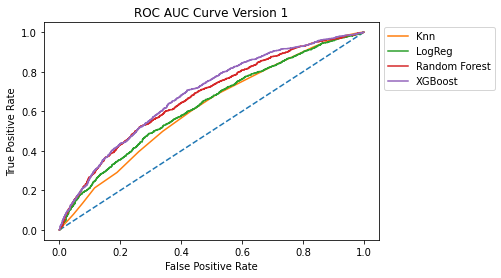

In [112]:
# ROC AUC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba, pos_label=1)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_proba, pos_label=1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba, pos_label=1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba, pos_label=1)
x_ = np.linspace(0, 1, 1000)
y_ = x_
plt.plot(x_, y_, '--')
plt.plot(fpr_knn, tpr_knn, label='Knn')
plt.plot(fpr_logreg, tpr_logreg, label='LogReg')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1,1))
plt.title('ROC AUC Curve Version 1');

XGBoost outperforms the other models in terms of ROC. 
Potential threshold is 0.4. 

<AxesSubplot:xlabel='param_knn__n_neighbors', ylabel='mean_test_score'>

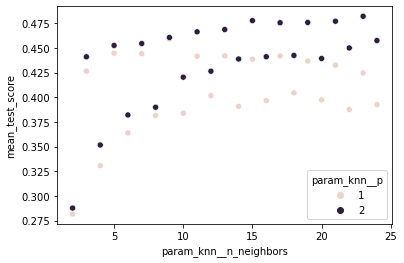

In [113]:
knn_df = pd.DataFrame(knn.cv_results_)
sns.scatterplot(x='param_knn__n_neighbors', y='mean_test_score', data=knn_df, hue='param_knn__p')

<AxesSubplot:xlabel='param_rf__n_estimators', ylabel='mean_test_score'>

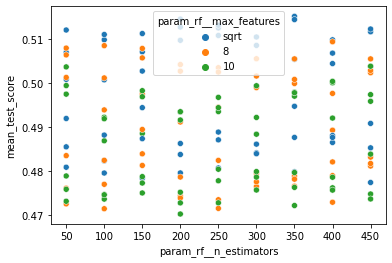

In [114]:
rf_df = pd.DataFrame(rf.cv_results_)
sns.scatterplot(x='param_rf__n_estimators', y='mean_test_score', data=rf_df, hue='param_rf__max_features')

In [51]:
knn.score(X_test, y_test)

0.476843582546568

### Comparing Models to Test Data

In [115]:
# putting train scores onto same DataFrame
models = ['knn', 'logreg', 'rf', 'xgb']
scores = pd.DataFrame()

for name in models:
    model = eval(name)
    currdf = pd.DataFrame(zip(len(model.cv_results_['mean_test_score'])*[name], model.cv_results_['mean_test_score']))
    scores = pd.concat([scores, currdf])
scores.columns=['model', 'score']

<AxesSubplot:xlabel='model', ylabel='score'>

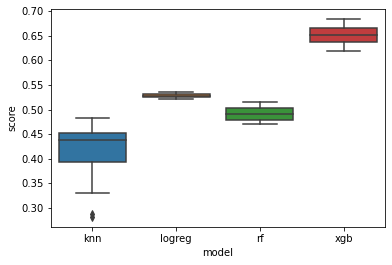

In [116]:
sns.boxplot(x='model', y='score', data=scores)

In [97]:
from sklearn.metrics import accuracy_score

In [118]:
accuracy_score(y_test, vote.predict(X_test))

0.6405228758169934

In [126]:
print(classification_report(y_holdout, vote.predict(X_holdout)))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       623
           1       0.51      0.57      0.54       381

    accuracy                           0.63      1004
   macro avg       0.61      0.62      0.62      1004
weighted avg       0.64      0.63      0.63      1004



<AxesSubplot:>

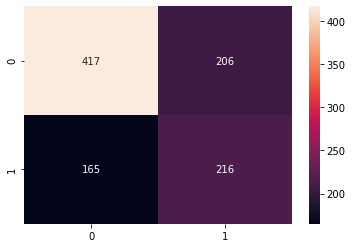

In [129]:
sns.heatmap(confusion_matrix(y_holdout, vote.predict(X_holdout)), annot=True, fmt='d')

In [130]:
X_test.columns

Index(['temp_avg', 'ws_avg', 'press_avg', 'humid_avg', 'dp_avg', 'under_dp',
       'temp_kelvin', 'year', 'month', 'PRCP', 'SNOW', 'lat', 'lon',
       'distance', 'distance_delta', 'press_delta', 'temp_trend',
       'press_trend', 'humid_trend', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [143]:
X_test.iloc[4,:]

temp_avg            64.300000
ws_avg              11.600000
press_avg           30.000000
humid_avg           89.500000
dp_avg              61.500000
under_dp             1.000000
temp_kelvin        291.094444
year              2005.000000
month                7.000000
PRCP                 1.170000
SNOW                 0.000000
lat                 38.100000
lon                -77.450000
distance           402.720884
distance_delta    -586.267451
press_delta          0.000000
temp_trend          -6.037037
press_trend         -0.066667
humid_trend          3.566667
month_1              0.000000
month_2              0.000000
month_3              0.000000
month_4              0.000000
month_5              0.000000
month_6              0.000000
month_7              1.000000
month_8              0.000000
month_9              0.000000
month_10             0.000000
month_11             0.000000
month_12             0.000000
Name: 5549, dtype: float64

In [149]:
rf.best_estimator_.

<bound method Pipeline.get_params of Pipeline(steps=[('sample', SMOTE()),
                ('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        min_samples_split=10,
                                        n_estimators=350))])>

In [153]:
rf.best_estimator_.get_params()

{'memory': None,
 'steps': [('sample', SMOTE()),
  ('rf',
   RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=10,
                          n_estimators=350))],
 'verbose': False,
 'sample': SMOTE(),
 'rf': RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=10,
                        n_estimators=350),
 'sample__k_neighbors': 5,
 'sample__n_jobs': None,
 'sample__random_state': None,
 'sample__sampling_strategy': 'auto',
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': 5,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 10,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 350,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [7]:
rf_base = baseline['random forest']

In [8]:
rf_base.feature_importances_

array([0.07099019, 0.09592823, 0.0532542 , 0.09869734, 0.07734345,
       0.01172515, 0.07279215, 0.06245534, 0.02913484, 0.05023233,
       0.00542585, 0.01746391, 0.02022204, 0.0190863 , 0.01519899,
       0.01209277, 0.07872197, 0.07086326, 0.08938995, 0.00381061,
       0.0039214 , 0.00452915, 0.00542705, 0.0053145 , 0.00474548,
       0.00365408, 0.00330894, 0.00305838, 0.00359966, 0.00406859,
       0.00354391])

In [11]:
list(zip(X_test.columns, rf_base.feature_importances_))

[('temp_avg', 0.07099019072753734),
 ('ws_avg', 0.09592822859997413),
 ('press_avg', 0.05325420141135463),
 ('humid_avg', 0.09869734475166372),
 ('dp_avg', 0.07734345394286397),
 ('under_dp', 0.011725152448793158),
 ('temp_kelvin', 0.07279215269739209),
 ('year', 0.062455339327712536),
 ('month', 0.02913483610991579),
 ('PRCP', 0.050232329729201),
 ('SNOW', 0.005425850471886307),
 ('lat', 0.017463908609129608),
 ('lon', 0.02022204321939658),
 ('distance', 0.01908629781544322),
 ('distance_delta', 0.015198986570212089),
 ('press_delta', 0.01209276680250362),
 ('temp_trend', 0.07872197204590342),
 ('press_trend', 0.07086325542661144),
 ('humid_trend', 0.08938995391132824),
 ('month_1', 0.0038106129955003645),
 ('month_2', 0.003921403460687991),
 ('month_3', 0.00452914726280196),
 ('month_4', 0.005427048906904646),
 ('month_5', 0.005314495359596748),
 ('month_6', 0.004745478438959213),
 ('month_7', 0.0036540794535908083),
 ('month_8', 0.0033089376770246504),
 ('month_9', 0.003058375468037

In [19]:
baseline['random forest'].feature_importances_

array([0.07099019, 0.09592823, 0.0532542 , 0.09869734, 0.07734345,
       0.01172515, 0.07279215, 0.06245534, 0.02913484, 0.05023233,
       0.00542585, 0.01746391, 0.02022204, 0.0190863 , 0.01519899,
       0.01209277, 0.07872197, 0.07086326, 0.08938995, 0.00381061,
       0.0039214 , 0.00452915, 0.00542705, 0.0053145 , 0.00474548,
       0.00365408, 0.00330894, 0.00305838, 0.00359966, 0.00406859,
       0.00354391])